In [1]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils
import skxray.core.speckle as speckle

import numpy as np
import os, sys

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm


interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
cd ..

/home


In [3]:
ls

cmazzoli/  dchabot/  hmiao/  mizuki/   swilkins/  xmchen/
dallan/    dmeyers/  mdean/  sameera/  vthampy/


In [4]:
cd xmchen

/home/xmchen


In [5]:
cd stuart-notebooks/

/home/xmchen/stuart-notebooks


In [6]:
ls


10932_10932_all_frames_div_Gc.npy
10932_10933_all_frames_div_Gc.npy
10936_10937_all_frames_div_Gc.npy
10958_10957_all_frames_div_Gc.npy
10967_10965_all_frames_div_Gc.npy
10984_10985_all_frames_div_Gc_201.npy
10984_10985_all_frames_div_Gc2_All.npy
10984_10985_all_frames_div_Gc.npy
11127_11126_part_frames_div_Gc.npy
11238to11240_11236_all_frames_div_Gc.npy
11262_11126_all_frames_div_Gc.npy
11262_11126_all_frames_div_Gc_small.npy
50668_50667_all_frames_div_Gc.npy
50678_50679_all_frames_div_Gc2.npy
50678_50679_all_frames_div_Gc.npy
ccdLmBgFlatAll_10K.npy
ccdLmBgFlatAll_10Kp1.npy
Create_avg_image_with_Gain_adjusted_bg_subtraction.ipynb
Create_avg_image_with_One_Gain_adjusted_bg_subtraction-Copy0.ipynb
Create_avg_image_with_One_Gain_adjusted_bg_subtraction.ipynb
Detector_analysis_Xiao.ipynb
dmexample-Copy0.ipynb
dmexample.ipynb
Escan bg sub.ipynb
fastCCDstats.ipynb
ff_10_sec_each_col.npy
find temperature.ipynb
fitfuncs.py
fitfuncs.pyc
fitIQ_15K.npy
Gain Calculation.ipynb
Gain_correction_5068

### Get the data and take out the bad frames

In [7]:
#LBCO_data = np.load("10984_10985_all_frames_div_Gc_All.npy")
LBCO_data = np.load("10984_10985_all_frames_div_Gc2_All.npy")

In [8]:
LBCO_ndata = np.delete(LBCO_data, 271, 0)
LBCO_ndata = np.delete(LBCO_ndata, 825, 0)

In [9]:
LBCO_data.shape

(900, 960, 960)

In [10]:
LBCO_ndata.shape

(898, 960, 960)

In [11]:
#  get the average image
avg_img = np.average(LBCO_ndata, axis=0)

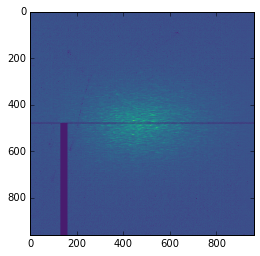

In [12]:
plt.imshow(avg_img, cmap='viridis')
plt.show()

### Create a RIngs(ROI"s")
Use the skxray.core.roi module to create Ring ROIs (ROI Mask).¶ 
(https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/roi.py)


In [13]:
# define the ROIs
roi_start = 20 # in pixels
roi_width = 1 # in pixels
roi_spacing = 1
center = (467, 470)
#x_center = 7. # in pixels
#y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, center, LBCO_ndata[0].shape)


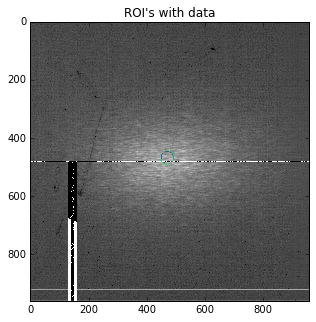

In [14]:
# plot the figure
fig, axes = plt.subplots(figsize=(5, 5))
axes.set_title("ROI's with data")
im = mpl_plot.roi.show_label_array_on_image(axes, avg_img, labeled_roi_array,
                                        cmap='viridis')
plt.show()


### Use the 1-time correlation function in scikit-xray

In [15]:
num_levels = 1
num_buf = 100
# g2 one time correlation results for 3 ROI's
g2, lag_steps = corr.multi_tau_auto_corr(
    num_levels, num_buf, labeled_roi_array, LBCO_ndata)

In [16]:
g2.shape

(100, 3)

### Plot the one time correlation functions

In [17]:
roi_names = ['gray', 'orange', 'brown']

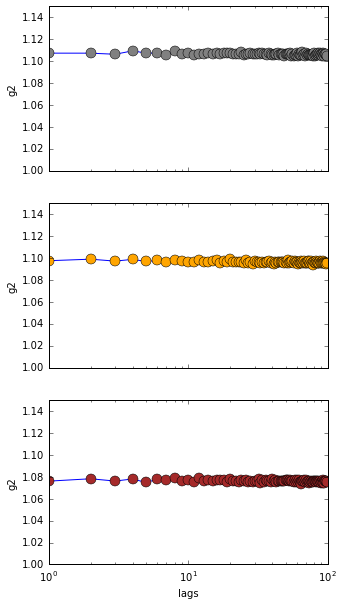

In [18]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lag_steps, g2[:, i], '-o', markerfacecolor=roi_color, markersize=10)
    axes[i].set_ylim(bottom=1, top=1.15)
plt.show()


### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [19]:
images_sets= (LBCO_ndata,)
max_cts = roi.roi_max_counts(images_sets, labeled_roi_array)
max_cts

12.477610667644971

### Get the mean intensity of each ring

In [20]:
mean_int_sets, index_list = roi.mean_intensity(LBCO_ndata, labeled_roi_array)
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring


array([ 2.09421554,  2.11494961,  2.14295709])

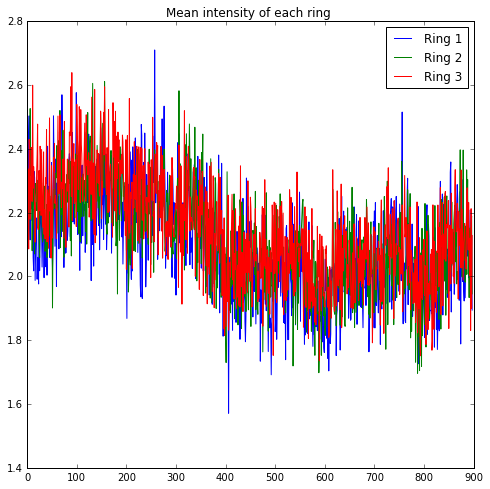

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Mean intensity of each ring ")
for i in range(num_rings):
    plt.plot(mean_int_sets[:,i], label="Ring "+str(i+1))
plt.legend()    
plt.show()

### Get the normalized bin edges and bin centers for each integration time.
using skxray.core.speckle.normalize_bin_edges

In [22]:
num_times = 4
num_rois = num_rings
norm_bin_edges, norm_bin_centers = speckle.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

### X-ray speckle visibilty spectroscopy
This function will provide the probability density of detecting photons
for different integration time. Using skxray.core.speckle module

In [23]:
spe_cts_all, std_dev = speckle.xsvs(images_sets, labeled_roi_array, timebin_num=2,
                             number_of_img=10, max_cts=max_cts)

### Find the integration times
using skxray.core.utils.geometric_series

In [24]:
time_steps = utils.geometric_series(2, 10)
time_steps

[1, 2, 4, 8]

### 1st q ring

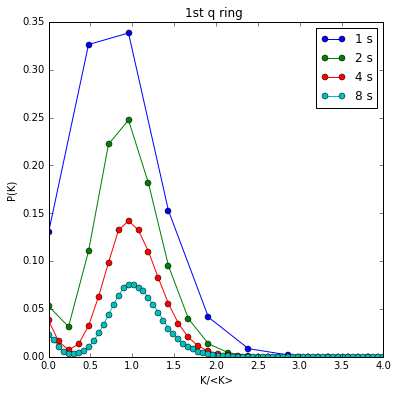

In [25]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o',
                     label=str(time_steps[i])+" s")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring ")
plt.show()

### 2nd q ring

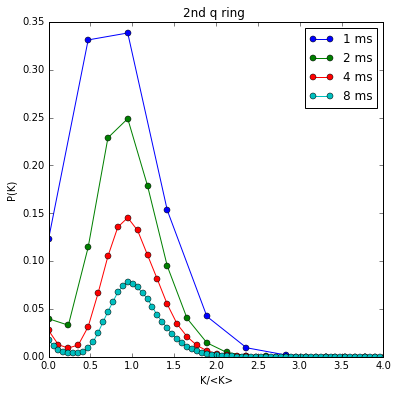

In [26]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], spe_cts_all[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("2nd q ring ")
plt.show()

### 3rd q ring

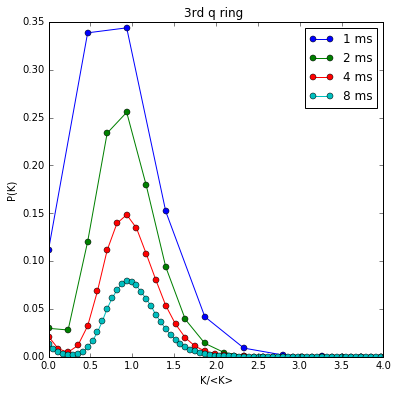

In [27]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 2], '-o',
                     label=str(time_steps[i])+" ms" )
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("3rd q ring ")
plt.show()

###  Different ROI and repeted the above steps

In [28]:
# define the ROIs
roi_start = 40 # in pixels
roi_width = 1 # in pixels
roi_spacing = 1
center = (467, 470)
#x_center = 7. # in pixels
#y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges_2 = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array_2 = roi.rings(
    edges_2, center, LBCO_ndata[0].shape)


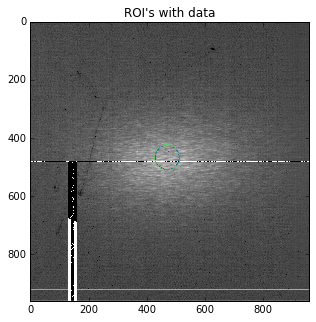

In [29]:
# plot the figure
fig, axes = plt.subplots(figsize=(5, 5))
axes.set_title("ROI's with data")
im = mpl_plot.roi.show_label_array_on_image(axes, avg_img, labeled_roi_array_2,
                                        cmap='viridis')
plt.show()


In [30]:
num_levels =9
num_buf = 8
# g2 one time correlation results for 3 ROI's
g2_2, lag_steps = corr.multi_tau_auto_corr(
    num_levels, num_buf, labeled_roi_array_2, LBCO_ndata)

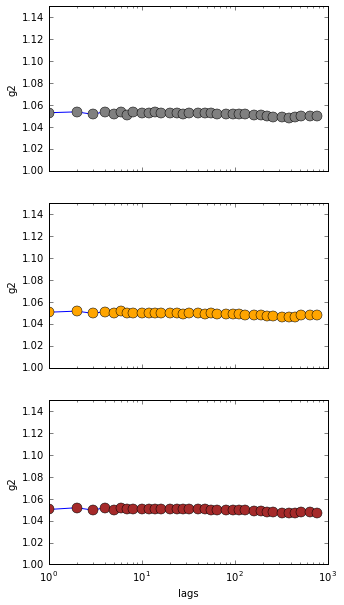

In [31]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lag_steps, g2_2[:, i], '-o',
                     markerfacecolor=roi_color, markersize=10)
    axes[i].set_ylim(bottom=1, top=1.15)
plt.show()


In [32]:
max_cts = roi.roi_max_counts(images_sets, labeled_roi_array_2)
max_cts

104.34178714203199

In [33]:
mean_int_sets, index_list = roi.mean_intensity(LBCO_ndata, labeled_roi_array_2)
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring


array([ 2.03911915,  2.09115193,  2.08332553])

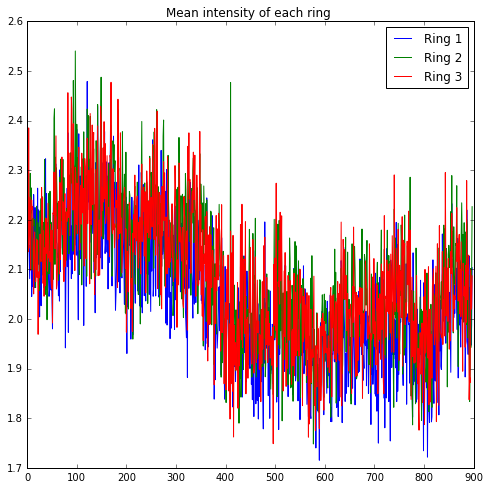

In [34]:
plt.figure(figsize=(8, 8))
plt.title("Mean intensity of each ring ")
for i in range(num_rings):
    plt.plot(mean_int_sets[:,i], label="Ring "+str(i+1))
plt.legend()    
plt.show()

In [35]:
num_times = 4
num_rois = num_rings
norm_bin_edges, norm_bin_centers = speckle.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

In [36]:
p_k, std_dev = speckle.xsvs(images_sets, labeled_roi_array_2, timebin_num=2,
                             number_of_img=10, max_cts=max_cts)

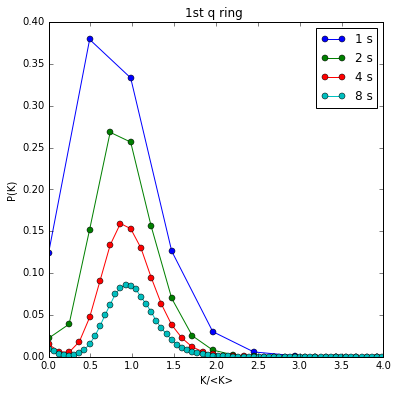

In [37]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], p_k[i, 0], '-o',
                     label=str(time_steps[i])+" s")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring ")
plt.show()